Clayton Cohn<br>
DePaul University<br>
19 Apr 2021<br>

#<center> Tagging Concepts in Causal Chains w/ BERT

This code was adapted from Drew Perkins' tutorial via Towards Data Science: 

https://towardsdatascience.com/tagging-genes-and-proteins-with-biobert-c7b04fc6eb4f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The below cell is for combining the *big* and *little* datasets if we want to do cross-validation. For this notebook, I simply used both the big and little datasets as-is.

In [ ]:
'''
This cell used to concatenate big and little partitions
'''

# import pandas as pd

# DATA_PATH = "drive/My Drive/colab/DeepNLP/data/"
# FILE_NAME1 = "EBA1415-SkinCancer-big-reln-repeat-iob2.csv"
# FILE_NAME2 = "EBA1415-SkinCancer-little-reln-repeat-iob2.csv"

# df1 = pd.read_csv(DATA_PATH + FILE_NAME1)
# df2 = pd.read_csv(DATA_PATH + FILE_NAME2)

# print("1:", len(df1))
# print("2:", len(df2))

# df = pd.concat([df1, df2], ignore_index=True)
# print(len(df))

# print(df.head())

# df.to_csv(DATA_PATH + 'EBA1415-SkinCancer-join-reln-repeat-iob2.csv', index=False)

'\nThis cell used to concatenate big and little partitions\n'

In [ ]:
DATA_PATH = "drive/My Drive/colab/DeepNLP/data/"
FILE_NAME = "EBA1415-SkinCancer-big-reln-repeat-iob2.csv"

In [ ]:
import pandas as pd

df = pd.read_csv(DATA_PATH + FILE_NAME)
df.head(25)

,Sentence #,Word,STag,Tag,Relation,File
0,Sentence 1,This,O,O,O,EBA1415_TFHC_1_SC_ES-05947
1,NaN,essay,O,O,O,NaN
2,NaN,is,O,O,O,NaN
3,NaN,about,O,O,O,NaN
4,NaN,skin,O,O,O,NaN
5,NaN,damage,O,O,O,NaN
6,NaN,",",O,O,O,NaN
7,NaN,latitude,O,O,O,NaN
8,NaN,and,O,O,O,NaN
9,NaN,direct,O,O,O,NaN


This was the raw dataset taken from the wiki. It has a lot of extraneous information that needs to be stripped. Considering that this is a tagging task, all we are concerned with is the sentence numberm, word, and label.

Additionally, the sentence numbers need to be added, as currently only the first word of each sentence has a number.

In [ ]:
import numpy as np

df_num = df.copy(deep=True)
df_num.iloc[0]["Sentence #"] = 0
df_num.drop(['File', 'Relation', 'STag'], axis=1, inplace=True)
df_num.columns = ["s_num","word","tag"]
df_num = df_num.fillna(-1)

snum = -1
for idx, row in df_num.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_num.head(25)

,s_num,word,tag
0,0,This,O
1,0,essay,O
2,0,is,O
3,0,about,O
4,0,skin,O
5,0,damage,O
6,0,",",O
7,0,latitude,O
8,0,and,O
9,0,direct,O


Once we have the cleaned and trimmed dataset we can make sure that there are no ```null``` values and also properly format the columns. This is also a good time to do some EDA and take a peek at the data.

In [ ]:
print("Any nulls? ", df_num.isnull().values.any())

Any nulls?  False


In [ ]:
df_num["s_num"] = df_num["s_num"].astype(str).astype(int)
df_num["word"] = df_num["word"].astype(str)

In [ ]:
print("Shape:", df_num.shape)
print(df_num.info())

Shape: (191903, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191903 entries, 0 to 191902
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   s_num   191903 non-null  int64 
 1   word    191903 non-null  object
 2   tag     191903 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB
None


In [ ]:
print("Unique labels:")
sorted(df_num.tag.unique())

Unique labels:


['B-1',
 'B-11',
 'B-12',
 'B-2',
 'B-3',
 'B-4',
 'B-5',
 'B-50',
 'B-6',
 'B-ANAPHOR',
 'B-BCK',
 'B-EXPLICIT',
 'B-ND',
 'B-OTHER',
 'B-RHETORICAL',
 'I-1',
 'I-11',
 'I-12',
 'I-2',
 'I-3',
 'I-4',
 'I-5',
 'I-50',
 'I-6',
 'I-ANAPHOR',
 'I-BCK',
 'I-EXPLICIT',
 'I-ND',
 'I-OTHER',
 'I-RHETORICAL',
 'O']

There are a bunch of labels that do not correlate to actual concepts in our causal model, so we need to transform those into "O" tags. In this notebook we are only concerned with tagging the actual concepts found in the causal model.  

In [ ]:
invalids = {"B-ANAPHOR", "B-BCK", "B-CHANGE-FACTOR", "B-EXPLICIT", "B-ND", "B-OTHER", "B-RHETORICAL", \
            "I-ANAPHOR", "I-CHANGE-FACTOR", "I-EXPLICIT", "I-ND", "I-OTHER", "I-RHETORICAL", "I-BCK", "B-BCK"}

In [ ]:
df_num["tag"] = df_num.apply(lambda x: "O" if x["tag"] in invalids else x["tag"], axis=1)

Below are the label counts for all of the concepts (and the "O" label).

In [ ]:
print(df_num.tag.value_counts())

O       139582
I-50      9561
I-6       5703
I-1       5420
I-2       4888
B-50      3872
I-3       3526
I-5       2933
I-4       2924
B-5       2863
B-2       2365
B-1       1925
B-3       1871
B-6       1308
B-4       1005
B-12       777
B-11       489
I-11       456
I-12       435
Name: tag, dtype: int64


In [ ]:
print(df_num.s_num.value_counts()[:10])

2359    123
2361    123
2360    123
7635     91
9331     83
4135     73
6138     71
6137     71
2018     71
6139     71
Name: s_num, dtype: int64


The ```SentenceGetter``` class extracts the sentences from the DataFrame.

In [ ]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, l) for w, l in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
      self.grouped = self.data.groupby("s_num").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [ ]:
getter = SentenceGetter(df_num)

In [ ]:
sents = [[word[0] for word in sentence] for sentence in getter.sentences]
sents[1]

['The',
 'skin',
 'damage',
 'is',
 'on',
 'our',
 'bodies',
 'that',
 'have',
 'numerous',
 'skin',
 'disorders',
 ',',
 'conditions',
 ',',
 'and',
 'diseases',
 '.']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', 'B-4', 'I-4', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We create a set of all tag values, i.e. concepts. We also add ```PAD``` as a value, as it will be used by BERT as the token for sequence padding.

The ```tag2idx``` dictionary assigns each tag a numerical value, as we are required by BERT to represent labels via integers.

In [ ]:
tag_values = list(set(df_num["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'B-1': 17,
 'B-11': 11,
 'B-12': 8,
 'B-2': 0,
 'B-3': 2,
 'B-4': 7,
 'B-5': 1,
 'B-50': 5,
 'B-6': 9,
 'I-1': 6,
 'I-11': 16,
 'I-12': 3,
 'I-2': 14,
 'I-3': 18,
 'I-4': 15,
 'I-5': 12,
 'I-50': 13,
 'I-6': 10,
 'O': 4,
 'PAD': 19}

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.8.1+cu101'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

The next step is tokenize the sentences, get their input IDs from BERT, and tensorize them for training.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
def tokenize_with_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [tokenize_with_labels(sent, labs) for sent, labs in zip(sents, labels)]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

The ```MAX_LEN``` hyperparameter was set to the maximum length instance.

In [ ]:
MAX_LEN = max(map(len, tokenized_texts))
BATCH_SIZE = 32
print("MAX_LEN:",MAX_LEN)

MAX_LEN: 139


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.5.1'

Create our instance of the PyTorch pretrained BERT model for set up for token classification. 

We will also make sure it runs on our GPU.

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda();

Set parameters for fine-tuning, then train the model.

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.525524531010938


Epoch:  33%|███▎      | 1/3 [02:07<04:14, 127.09s/it]

Validation loss: 0.2694558725889885
Validation Accuracy: 0.9190702884346121

Average train loss: 0.21666424391488304


Epoch:  67%|██████▋   | 2/3 [04:14<02:07, 127.04s/it]

Validation loss: 0.2223393072120168
Validation Accuracy: 0.93330532997293

Average train loss: 0.15930300505000414


Epoch: 100%|██████████| 3/3 [06:20<00:00, 126.85s/it]

Validation loss: 0.21612014669473423
Validation Accuracy: 0.9379258844394661



See where the training loss meets the validation loss, and examine the accuracy score, classification report, and confusion matrix of the validation instances.

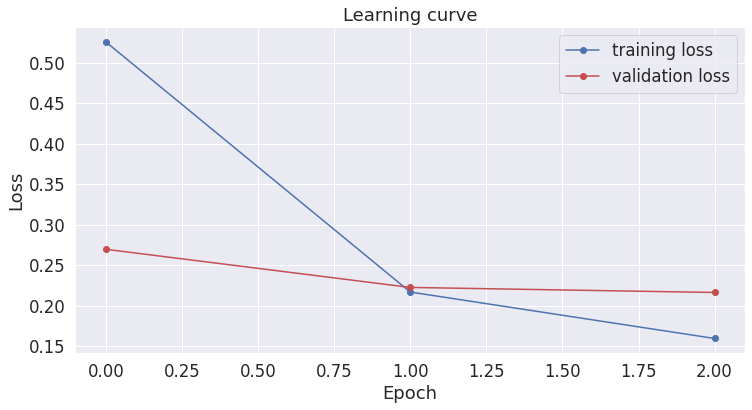

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

         B-1       0.74      0.72      0.73       213
        B-11       0.89      0.96      0.92       108
        B-12       0.81      0.81      0.81       103
         B-2       0.80      0.87      0.83       242
         B-3       0.89      0.90      0.90       304
         B-4       0.83      0.80      0.81       110
         B-5       0.88      0.96      0.92       504
        B-50       0.82      0.85      0.83       388
         B-6       0.75      0.73      0.74       131
         I-1       0.88      0.90      0.89       710
        I-11       0.97      0.96      0.97        75
        I-12       0.72      0.81      0.77        54
         I-2       0.87      0.84      0.85       480
         I-3       0.88      0.92      0.90       454
         I-4       0.88      0.85      0.87       313
         I-5       0.87      0.88      0.87       376
        I-50       0.91      0.89      0.90      1017
         I-6       0.83    

In [ ]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=50)
print(confusion_matrix(valid_tags, pred_tags))

[[  153     0     0 ...     0     0    33]
 [    0   104     0 ...     0     0     0]
 [    0     0    83 ...     0     0    13]
 ...
 [    0     0     0 ...   907     0    82]
 [    0     0     0 ...     0   513    28]
 [   28    12    18 ...    77    84 14683]]


Now it's time to evaluate the test data. Like the training dataset, this partition also needs to be cleaned and stripped.


In [ ]:
FILE_NAME = "EBA1415-SkinCancer-little-reln-repeat-iob2.csv"

In [ ]:
df = pd.read_csv(DATA_PATH + FILE_NAME)
df.head(25)

,Sentence #,Word,STag,Tag,Relation,File
0,Sentence 1,The,O,O,O,EBA1415_TFHC_4_SC_ES-05825
1,NaN,lead,O,O,O,NaN
2,NaN,to,O,O,O,NaN
3,NaN,skin,O,O,O,NaN
4,NaN,cancer,O,O,O,NaN
5,NaN,differ,O,O,O,NaN
6,NaN,on,O,O,O,NaN
7,NaN,a,O,O,O,NaN
8,NaN,few,O,O,O,NaN
9,NaN,things,O,O,O,NaN


In [ ]:
df_test = df.copy(deep=True)
df_test.iloc[0]["Sentence #"] = 0
df_test.drop(['File', 'Relation', 'STag'], axis=1, inplace=True)
df_test.columns = ["s_num","word","tag"]
df_test = df_test.fillna(-1)

snum = -1
for idx, row in df_test.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_test.head(25)

,s_num,word,tag
0,0,The,O
1,0,lead,O
2,0,to,O
3,0,skin,O
4,0,cancer,O
5,0,differ,O
6,0,on,O
7,0,a,O
8,0,few,O
9,0,things,O


In [ ]:
print("Any nulls? ", df_test.isnull().values.any())

Any nulls?  False


In [ ]:
df_test["s_num"] = df_test["s_num"].astype(str).astype(int)

In [ ]:
print("Shape:", df_test.shape)
print(df_test.info())

Shape: (48733, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48733 entries, 0 to 48732
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s_num   48733 non-null  int64 
 1   word    48733 non-null  object
 2   tag     48733 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None


In [ ]:
print("Unique labels:")
sorted(df_test.tag.unique())

Unique labels:


['B-1',
 'B-11',
 'B-12',
 'B-2',
 'B-3',
 'B-4',
 'B-5',
 'B-50',
 'B-6',
 'B-ANAPHOR',
 'B-EXPLICIT',
 'B-ND',
 'B-RHETORICAL',
 'I-1',
 'I-11',
 'I-12',
 'I-2',
 'I-3',
 'I-4',
 'I-5',
 'I-50',
 'I-6',
 'I-ANAPHOR',
 'I-EXPLICIT',
 'I-ND',
 'I-RHETORICAL',
 'O']

In [ ]:
df_test["tag"] = df_test.apply(lambda x: "O" if x["tag"] in invalids else x["tag"], axis=1)

In [ ]:
print(df_test.tag.value_counts()[:10])

O       35401
I-50     2416
I-6      1496
I-1      1390
I-2      1372
B-50      960
I-3       890
I-4       752
B-5       720
I-5       679
Name: tag, dtype: int64


In [ ]:
print(df_test.s_num.value_counts()[:10])

1471    82
1470    82
1474    82
1473    82
1475    82
1472    82
2299    77
2297    77
2300    77
2298    77
Name: s_num, dtype: int64


We'll first take a look at a sample sentence to see what the model predicts for the tags versus what the tags actually were.

In [ ]:
n = 3
first_sent_word = list(df_test[df_test["s_num"] == n]["word"])
first_sent_label = ["O"] + list(df_test[df_test["s_num"] == n]["tag"])

test_sentence = ""
for val in first_sent_word:
  test_sentence += val + ' '

test_tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(test_input_ids)
test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
print(output)
test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token, idx in zip(test_tokens, test_label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[idx])
        new_tokens.append(token)
for token, label, old in zip(new_tokens, new_labels, first_sent_label):
    print("{}\t{}\t{}".format(label, token, old))

The reason the sun matters is because of the direct uvb rotation hiting that location . 
TokenClassifierOutput(loss=None, logits=tensor([[[-5.4622e-01,  7.1742e-02,  2.4231e-01, -9.9848e-01,  1.3188e+00,
          -5.1000e-01, -1.0347e+00, -7.9683e-01, -9.5585e-01,  1.4793e+00,
          -5.9209e-01, -6.6431e-01,  5.9453e-02, -9.6791e-01, -2.8737e-01,
          -8.1046e-01, -2.3176e-01,  4.6512e+00, -1.0663e-01, -1.2759e+00],
         [ 4.2379e-02, -3.6677e-01, -1.7986e-01, -6.9081e-01, -2.0748e-01,
           1.0564e-01, -6.4837e-01, -4.4868e-01, -5.5550e-01,  6.4378e-01,
          -1.7701e-01, -4.1943e-01, -6.1000e-01, -1.3322e+00, -3.0420e-01,
          -9.3163e-01, -3.1062e-02,  4.5122e+00,  4.2048e-01, -1.5531e+00],
         [-7.6158e-01,  8.6726e-01,  2.4161e-01, -1.0224e+00,  1.2447e+00,
          -5.7898e-01, -4.1129e-01, -1.1951e+00, -9.1874e-01,  3.6868e-01,
          -4.1005e-01, -7.3188e-01, -6.2798e-01, -5.8405e-01,  4.9490e-01,
          -8.7834e-01, -1.1849e+00,  6.4276e

Now is the actual evaluation of the entire test set, followed by the classification report and confusion matrix.

In [ ]:
y_pred = []
y_true = []
y_tokens = []

for i in range(max(df_test["s_num"]+1)):
  first_sent_word = list(df_test[df_test["s_num"] == i]["word"])
  first_sent_label = ["O"] + list(df_test[df_test["s_num"] == i]["tag"]) + ["O"]

  test_sentence = ""
  for val in first_sent_word:
    test_sentence += val + ' '
  # print(test_sentence) 

  test_tokenized_sentence = tokenizer.encode(test_sentence)
  test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(test_input_ids)
  test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, idx in zip(test_tokens, test_label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[idx])
          new_tokens.append(token)
  y_pred += new_labels
  y_true += first_sent_label
  y_tokens += new_tokens
# print(len(y_pred))
# print(len(y_true))

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)
print(report)

{'B-1': {'precision': 0.5901060070671378, 'recall': 0.7455357142857143, 'f1-score': 0.6587771203155819, 'support': 448}, 'B-11': {'precision': 0.7315436241610739, 'recall': 0.9083333333333333, 'f1-score': 0.8104089219330856, 'support': 120}, 'B-12': {'precision': 0.6382113821138211, 'recall': 0.8010204081632653, 'f1-score': 0.7104072398190046, 'support': 196}, 'B-2': {'precision': 0.6727037516170763, 'recall': 0.8227848101265823, 'f1-score': 0.7402135231316727, 'support': 632}, 'B-3': {'precision': 0.7528830313014827, 'recall': 0.9364754098360656, 'f1-score': 0.834703196347032, 'support': 488}, 'B-4': {'precision': 0.660377358490566, 'recall': 0.6889763779527559, 'f1-score': 0.674373795761079, 'support': 254}, 'B-5': {'precision': 0.8240396530359355, 'recall': 0.9236111111111112, 'f1-score': 0.870988867059594, 'support': 720}, 'B-50': {'precision': 0.4908045977011494, 'recall': 0.8895833333333333, 'f1-score': 0.6325925925925926, 'support': 960}, 'B-6': {'precision': 0.6268656716417911,

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[  334     0     0 ...     0     0   100]
 [    0   109     0 ...     0     0    11]
 [    0     0   157 ...     0     0    30]
 ...
 [    0     0     0 ...  1959     0   238]
 [    0     0     0 ...     0  1074   297]
 [  117    32    72 ...   458   105 38281]]


In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report.head()

,precision,recall,f1-score,support
B-1,0.590106,0.745536,0.658777,448.0
B-11,0.731544,0.908333,0.810409,120.0
B-12,0.638211,0.801020,0.710407,196.0
B-2,0.672704,0.822785,0.740214,632.0
B-3,0.752883,0.936475,0.834703,488.0


In [ ]:
# df_report.to_csv(DATA_PATH + 'tagging_results_sc.csv')

In [ ]:
word_acc = {}

for word, true, pred in zip(y_tokens, y_true, y_pred):
  if word in word_acc:
    word_acc[word][1] += 1
    if pred == true: word_acc[word][0] += 1
  else:
    word_acc[word] = [1,1] if pred == true else [0,1]
  
word_acc = {k: [v[0]/v[1], v[1]] for k, v in word_acc.items()}
word_acc["the"]

[0.9197446420428637, 2193]

In [ ]:
word_arr = sorted(word_acc.items(), key=lambda item: item[1][1])
word_arr[-20:]

[('it', [0.9424603174603174, 504]),
 ('cells', [0.822550831792976, 541]),
 ('a', [0.9197080291970803, 548]),
 ('that', [0.927710843373494, 581]),
 ('are', [0.9324546952224053, 607]),
 ('and', [0.9559748427672956, 636]),
 ('in', [0.9010339734121122, 677]),
 ('can', [0.9420289855072463, 690]),
 ('/', [0.9788135593220338, 708]),
 ('you', [0.9228855721393034, 804]),
 ('is', [0.953059513830679, 1193]),
 ('to', [0.9139020537124802, 1266]),
 (',', [0.9663323782234957, 1396]),
 ('of', [0.9175977653631285, 1432]),
 ('cancer', [0.7672354948805461, 1465]),
 ('skin', [0.7397454031117398, 2121]),
 ('the', [0.9197446420428637, 2193]),
 ('.', [0.955, 2600]),
 ('[CLS]', [1.0, 2620]),
 ('[SEP]', [0.9721374045801526, 2620])]